# Online Portfolio Selection by Deep Learning
En este notebook entrenamos la red para que estime directamente los pesos óptimos para cada instante de tiempo. Estos pesos vendrán dados por la capa de salida, que contará con $N$ neuronas, siendo $N$ el número de activos.
1. $x[n]$ contiene los precios desde $p[n]$ hasta $p[n+T-1]$ (esto son $T$ días)
2. $y[n]$ se evalúa con el precio en $p[n+T]$. 
3. Por tanto los pesos en día $n+T-1$, $W[n+T-1]$ disponen de la información en $x[n]$ y se usan para predecir $y[n]$, que corresponde a los precios el día siguiente $n+T$, que es cuando se evalúa. 

**Índice**

1. [Definición del experimento](#Definición-del-experimento)
2. [Cargar Datos](#Cargar-datos)
3. [Deep Learning] (#Deep-Learning)
4. [Rozamientos] (#Análisis-de-los-rozamientos)

In [68]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import sys
import os
from sklearn.preprocessing import OneHotEncoder
import boto3
import funcion_limpieza_aws
import aws_function


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Definición del experimento
Primero las fechas: 

In [173]:
first_day = datetime(2007,8,1).date() # Esta es la fecha desde la cual tenemos datos
last_day = datetime(2016,12,31).date()
dates = pd.date_range(first_day, last_day, freq='B')

## Cargar datos

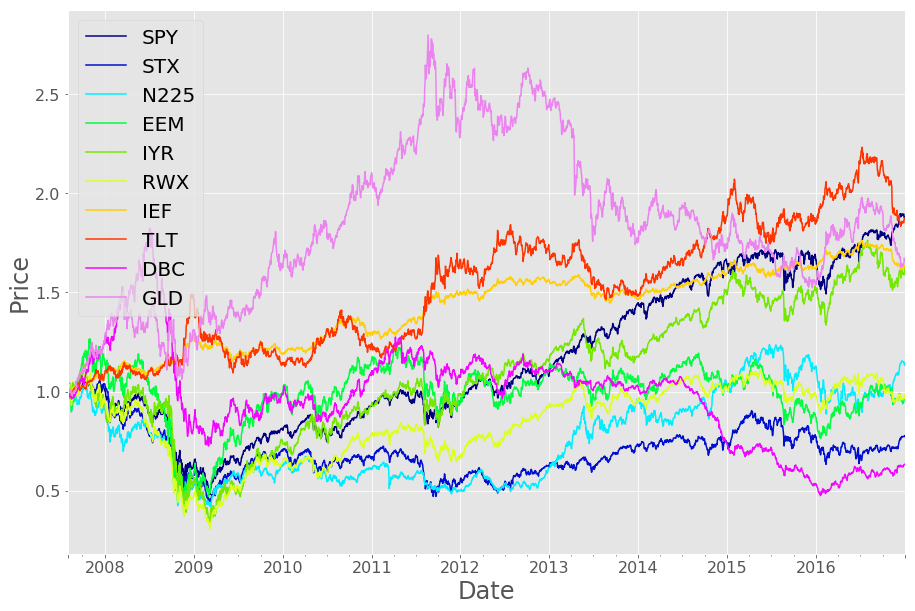

In [174]:
# Cargar datos de precios
# c = rest.Connection()
prices = aws_function.limpieza_csv_aws(
    'datostiempo')

# Post-processing

prices.fillna(method='ffill',limit=5,inplace=True) # Cleaning


# Dataframe with percentual changes
prices_pct = prices.pct_change(axis=0,fill_method='pad') # differences

prices_pct.fillna(0.,inplace=True)
Nassets = 10
L = len(prices_pct)
#(prices.div(prices.ix[0])-1).plot()
N = len(prices_pct.columns) # Number of assets
from cycler import cycler
colormap = plt.cm.gist_ncar
# Pintamos las series temporales que hemos obtenido
ax=(1+prices_pct).cumprod(axis=0).plot(color=[colormap(i) for i in np.linspace(0, 0.9, N)])
ax.legend(fontsize=20)
ax.set_xlabel('Date',fontsize=24)
ax.set_ylabel('Price',fontsize=24)
ax.tick_params(labelsize=16)

### Particionamos en Train/Validation/Test
* Los datos de entrenamiento y validación se adquieren con solape, para aumentar el número de ejemplos disponibles para entrenamiento. Por ejemplo, si se quiere implementar una estrategia semanal donde observamos los últimos 5 precios para establecer los pesos, tendríamos: 
- MXJV como input, retorno hasta el siguiente V como etiqueta,
- MXJVL como input, retorno hasta el siguiente L como etiqueta,
- etc
* Los datos de test no tendrían solape, y seguirían el patrón LMXJV de imput, retorno al siguiente V como etiqueta, para todas las semanas disponibles.

In [189]:
# Parámetros de la simulación
strategy_type = 'B' # La estrategia puede ser semanal ('W') o diaria ('B')
if strategy_type=='B':
    A = 1 # Número de días a los que evaluar el retorno.
elif strategy_type=='W':
    A = 3 # Si la estrategia es semanal, recomendamos los viernes
T = 3 # Número de días usados para la predicción
interleave = False # Si True, los datos de train y validación están intercalados en el tiempo

# Train data and labels
Ntr = 1500 # Number of training data 
Nval = 200 # Number of validation data
Ntt = L-T-A+1-Ntr-Nval# Number of test data

X = np.zeros((L-T-A+1,N*T)) # Component of the states due to the price history
R = np.zeros((L-T-A+1,N)) # Real Labels: return of the different actions
wd_ohe = np.zeros((L-T-A+1,5))# Day of week, OHE
for n in range(L-T-A+1):
    X[n,:]=np.reshape(prices_pct.values[n:n+T,:],[1,N*T])# observacion de los ultimos T precios
    wd_ohe[n,prices_pct.index[n+T-1].weekday()]=1.# dia de la semana en que se fijan los pesos
    R[n,:] = np.prod(1+prices_pct.values[n+T:n+T+A,:],axis=0)-1 # Retorno a predecir por la red. 

# X = np.hstack((X,wd_ohe)) # Esta línea añade el día de la semana

# Variable binaria que indica cuál es el activo más rentable
OHEncoder = OneHotEncoder(sparse=False)
Y = OHEncoder.fit_transform(np.argmax(R,axis=1).reshape(-1,1))

if interleave:
    inds = np.random.permutation(L-T-A+1)
else:
    inds = list(range(L-T-A+1))

# Datos de entrenamiento
Xtr = X[inds[:Ntr]] # inputs
Rtr = R[inds[:Ntr]] # retornos
Ytr = Y[inds[:Ntr]] # etiqueta OHE del activo más rentable
# Datos de validación
Xval = X[inds[Ntr:Ntr+Nval]] # inputs
Rval = R[inds[Ntr:Ntr+Nval]] # retornos
Yval = Y[inds[Ntr:Ntr+Nval]] 
# Datos de test
Xtt = X[inds[Ntr+Nval:Ntr+Nval+Ntt]] 
Rtt = R[inds[Ntr+Nval:Ntr+Nval+Ntt]] 
Ytt = Y[inds[Ntr+Nval:Ntr+Nval+Ntt]] 

weight_dates = prices.index[Ntr+Nval+T-1:-A]

"""
if strategy_type=='B': # Resolución semanal
    Xtt = X[Ntr+Nval:] 
    Rtt = R[Ntr+Nval:] 
    Ytt = Y[Ntr+Nval:] 
    weight_dates = prices.index[Ntr+Nval+T-1:-A] # Fechas en las que se establecen los pesos de acuerdo a cada observación
elif strategy_type=='W':
    Xtt = X[Ntr+Nval:][wd_ohe[Ntr+Nval:,-1]>0] 
    Rtt = R[Ntr+Nval:][wd_ohe[Ntr+Nval:,-1]>0] 
    Ytt = Y[Ntr+Nval:][wd_ohe[Ntr+Nval:,-1]>0] 
    weight_dates = prices.ix[Ntr+Nval+T-1:-A].resample('W-MON').last().index
"""
        



"\nif strategy_type=='B': # Resolución semanal\n    Xtt = X[Ntr+Nval:] \n    Rtt = R[Ntr+Nval:] \n    Ytt = Y[Ntr+Nval:] \n    weight_dates = prices.index[Ntr+Nval+T-1:-A] # Fechas en las que se establecen los pesos de acuerdo a cada observación\nelif strategy_type=='W':\n    Xtt = X[Ntr+Nval:][wd_ohe[Ntr+Nval:,-1]>0] \n    Rtt = R[Ntr+Nval:][wd_ohe[Ntr+Nval:,-1]>0] \n    Ytt = Y[Ntr+Nval:][wd_ohe[Ntr+Nval:,-1]>0] \n    weight_dates = prices.ix[Ntr+Nval+T-1:-A].resample('W-MON').last().index\n"

## Deep Learning
### Definición de la Red
Asumimos que hay *N* assets y *T* instantes para realizar la predicción 
El input a la red viene dado por los últimos retornos (dimensión *N x T*)

La capa de salida tiene $N$ neuronas. Entreneremos la red con la siguiente función de coste:

$L(w, r) = \log (1 + r_{y}) - \log (1 + \sum_i w_i r_i)$


Como puede apreciarse, $L(w,y) = 0$ únicamente si hemos concentrado toda la cartera en el activo que va a proporcionar el mayor retorno, es decir $w_i = 1_{[i=y]}$. En cualquier otro caso, el coste tendrá un valor positivo que dependerá del margen con el que nos alejamos de la cartera óptima. 

Definimos una arquitectura genérica y configurable (entre una y tres capas ocultas).

In [106]:
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import dropout
# Most generic model
class generic_NN():  # two-layers. In this case Nhidden is a 2-element list
    def __init__(self, D_in, D_out, Nhidden,learning_rate,keep_prob=None,kind='retmax'):
        # Parámetros de la red:
        # D_in: número de vars. de entrada.
        # D_out: número de salidas (igual al número de assets).
        # Nhidden es el array con número de neuronas en las capas ocultas
        # keep_prob = 1 - Pr(drop-out), Nono if no dropout
        # kind: 'softmax' ó 'retmax'

        # First layer
        self.input = tf.placeholder(shape=[None, D_in], dtype=tf.float32)
        self.is_training = tf.placeholder(tf.bool,shape=())
        if keep_prob is not None:
            X = dropout(self.input,keep_prob,is_training=self.is_training)
        else:
            X = self.input
        # 1st Hidden layer
        hidden1 = fully_connected(X,Nhidden[0])
        if keep_prob is not None:
            hidden1 = dropout(hidden1,keep_prob,is_training=self.is_training)
        # 2nd Hidden layer
        if len(Nhidden)>1:
            hidden2 = fully_connected(hidden1,Nhidden[1])
            if keep_prob is not None:
                hidden2 = dropout(hidden2,keep_prob,is_training=self.is_training)
            self.yout = fully_connected(hidden2, D_out, activation_fn=None)
            # 3rd Hidden layer
            if len(Nhidden) > 2:
                hidden3 = fully_connected(hidden2,Nhidden[2])
                if keep_prob is not None:
                    hidden3 = dropout(hidden3,keep_prob,is_training=self.is_training)
                self.yout = fully_connected(hidden3, D_out, activation_fn=None)
            else:
                self.yout = fully_connected(hidden2, D_out, activation_fn=None)
        else:
            self.yout = fully_connected(hidden1, D_out, activation_fn=None)

        self.probs = tf.nn.softmax(self.yout)

        self.r = tf.placeholder(shape=[None, D_out],
                                dtype=tf.float32)  # True returns: those that the network must estimate
        self.y = tf.placeholder(shape=[None, D_out], dtype=tf.float32)
        self.trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        self.returns = tf.log1p(tf.reduce_sum(tf.multiply(self.r, self.probs), axis=1))  # log. return
        if kind == 'retmax':
            self.loss = tf.reduce_mean(-self.returns)
        elif kind == 'softmax':
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.yout))

        self.updateModel = self.trainer.minimize(self.loss)

### Entrenamiento

In [190]:
# Some initializations:
num_steps = 1000000  # Número de minibatches que se usarán en entrenamiento
kind= 'retmax' # Opciones: "retmax" o "softmax"
keep_prob = .5 # Prob. de drop-out (keep_prob=None, if no dropout)
batch_size = 32
display_iter = num_steps/100 # ... de forma que las curvas de aprendizaje tengan 100 puntos
learning_rate = 1e-4
Nhidden = [512] # Num. de unidades en las capas ocultas (máxima tres capas)
# Training
tf.reset_default_graph()

DN = generic_NN(X.shape[1],N,Nhidden,learning_rate,keep_prob,kind)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
trainables = tf.trainable_variables()


# variables para la monitorización de la función de pérdidas
lossTrAvg = 0. # versión suavizada del error de train
lossTrList = []        
lossValList = []        
lossTestList = []        

# variables para la monitorización de los retornos
retTrAvg = 0.
retTrList = []        
retValList = []        
retTestList = []        


best_val_loss = np.inf # Best validation loss: used as a criterion to stop the training
best_tt_loss = 0. # Test loss obtained at the same step that the best val. loss is achieved

eq_test = np.zeros((int(num_steps/100),Ntt)) # En esta matriz guardaremos todas las evoluciones del equity

with tf.Session() as sess:
    tf.set_random_seed(1)
    sess.run(init)
    for i in range(num_steps):
        # Generate a minibatch.
        indices=(np.linspace(i * batch_size, (i+1)*batch_size-1,batch_size) % Ntr).astype(int)
        # Generate a minibatch.
        batch_data = Xtr[indices, :]
        batch_rets = Rtr[indices, :]
        batch_labels = Ytr[indices, :]

        #Entrenamiento
        _,retTr ,lossTr= sess.run([DN.updateModel,DN.returns,DN.loss], feed_dict={DN.input:batch_data,DN.r: batch_rets, 
                                                                                  DN.y:batch_labels,DN.is_training:True})
        lossTrAvg += lossTr/display_iter # Para pintar el coste en train promediamos 
        retTrAvg += np.mean(retTr)/display_iter
        if i%display_iter==0:
            lossTrList.append(lossTrAvg)
            retTrList.append(retTrAvg)
            lossTrAvg = 0.
            retTrAvg = 0.
            # Validación y test
            # Stop when the validation loss stops decreasing 
            # Predicción sobre cjto de validación
            loss_val,ret_val,p = sess.run([DN.loss,DN.returns,DN.probs], feed_dict={DN.input:Xval,DN.r:Rval,DN.y:Yval,DN.is_training:False})
            # Predicción sobre cjto de test
            loss_tt,ret_test,ptt = sess.run([DN.loss,DN.returns,DN.probs], feed_dict={DN.input:Xtt,DN.r:Rtt,DN.y:Ytt,DN.is_training:False})
            lossValList.append(loss_val)
            retValList.append(np.mean(ret_val))
            lossTestList.append(loss_tt)
            retTestList.append(np.mean(ret_test))
            eq_test[int(i/display_iter)] = np.exp(np.cumsum(ret_test))-1
            if loss_val<best_val_loss:
                best_val_loss = loss_val
                best_tt_loss = loss_tt
                best_val_ret = ret_val
                best_tt_ret = ret_test
                p_val = p
                p_test = ptt
                save_path=saver.save(sess,'./model.ckpt')
                                                
                                                
    max_ret_val = np.prod(np.max(Rval,axis=1)+1)-1
    max_ret_test = np.prod(np.max(Rtt,axis=1)+1)-1
    print('Neural Network: daily validation return: {:.4f}, daily test return: {:.4f}'.format(np.mean(best_val_ret),np.mean(best_tt_ret)))
    # Equally weighted benchmark:
    print('Equally-weighted CRP: daily validation return: {:.4f}, daily test return: {:.4f}'.format(np.mean(np.mean(Rval,axis=1)), np.mean(np.mean(Rtt,axis=1))))
    # Best asset benchmark:
    best_asset_val = np.argmax(np.prod(1+Rval,axis=0))
    best_asset_tt  = np.argmax(np.prod(1+Rtt,axis=0))
    print('Best asset: daily validation return: {:.4f}, daily test return: {:.4f}'.format(np.mean(Rval[:,best_asset_val]),np.mean(Rtt[:,best_asset_tt])))


Neural Network: daily validation return: 0.0025, daily test return: 0.0024
Equally-weighted CRP: daily validation return: -0.0001, daily test return: 0.0001
Best asset: daily validation return: 0.0006, daily test return: 0.0004


### Representación gráfica de la evolución de la función de pérdidas

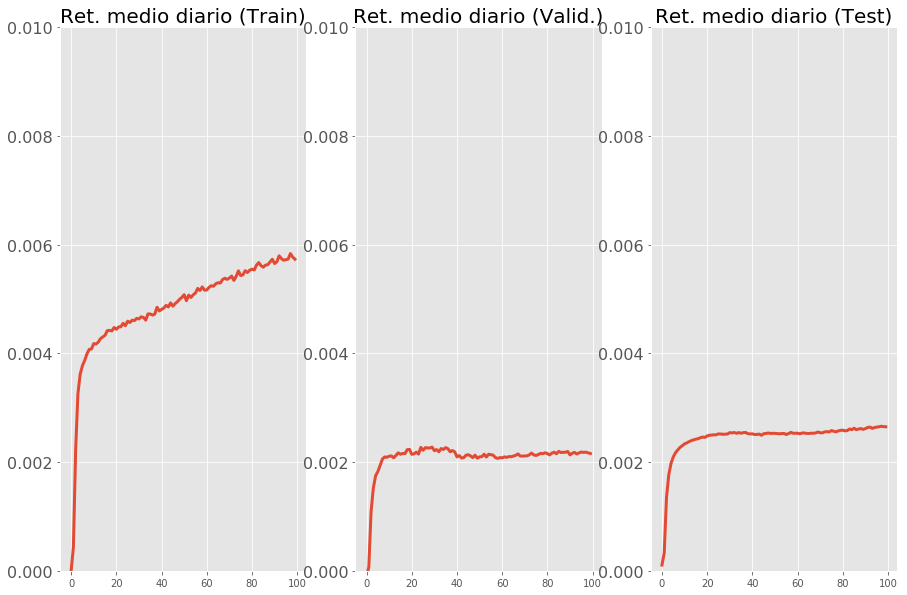

In [183]:
# Pintamos cómo evolucionan los retornos
plt.rcParams['ytick.labelsize'] = 16
fig = plt.figure()
ax0 = fig.add_subplot(1,3,1)
ax0.plot(retTrList,linewidth=3)
ax0.set_title('Ret. medio diario (Train)',fontsize=20)
ax0.set_ylim([.0,.01])
ax1 = fig.add_subplot(1,3,2)
ax1.plot(retValList,linewidth=3)
ax1.set_title('Ret. medio diario (Valid.)',fontsize=20)
ax1.set_ylim([.0,.01])
ax2 = fig.add_subplot(1,3,3)
ax2.plot(retTestList,linewidth=3)
ax2.set_title('Ret. medio diario (Test)',fontsize=20)
ax2.set_ylim([.0,.01])


# Pintamos cómo evoluciona la función de coste
if kind=='softmax':
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(lossValList,linewidth=3)
    ax1.set_title('Val. loss',fontsize=20)
    #ax1.set_ylim([.6,.7])
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(lossTestList,linewidth=3)
    ax2.set_title('Test loss',fontsize=20)
    #ax2.set_ylim([.6,.7])

## Análisis de la exposición

### Evolución de la exposición

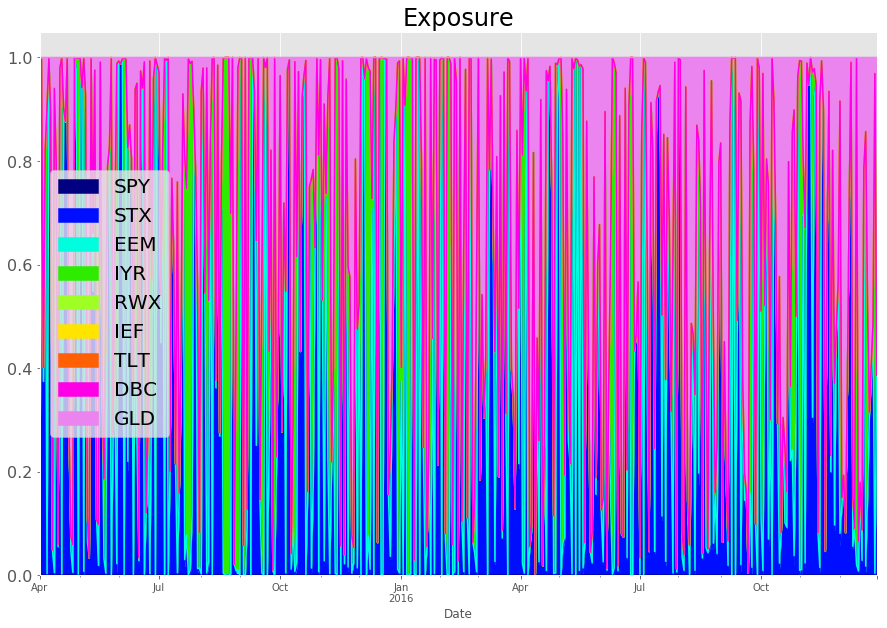

In [122]:
ax=positions.plot.area(color=[colormap(i) for i in np.linspace(0, 0.9, N)])
ax.legend(fontsize=20)
ax.set_title('Exposure', fontsize=24)

### Exposicón media a cada activo

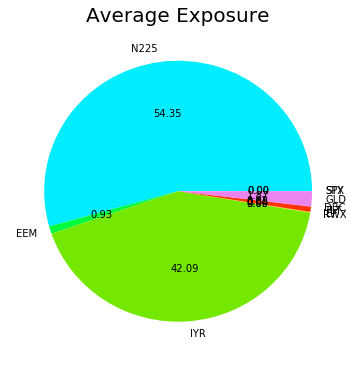

In [78]:
 
ax=positions.mean(axis=0).plot.pie(figsize=(6, 6),autopct='%.2f',colors=[colormap(i) for i in np.linspace(0, 0.9, N)])
ax.set_ylabel('')
ax.set_title('Average Exposure',fontsize=20)


### Aportaciones teóricas a la rentabilidad 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


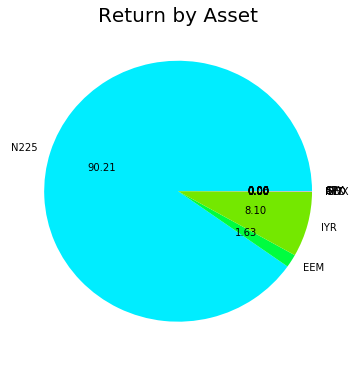

In [63]:
# Aportación teórica a la rentabilidad
def return_by_asset(returns,W):
    # Returns the return of each asset, so that the summation is equal to the return of the portfolio
    eq =  ((W.shift(1).fillna(0.) * returns).sum(axis=1) + 1).cumprod() - 1
    return (W.shift(1).fillna(0.) * returns).mul(1+eq.shift(1).fillna(0.),axis='rows').sum(axis=0)

rets_by_asset = return_by_asset(prices_pct.ix[T+Ntr+Nval:],positions)
rets_by_asset.values[rets_by_asset.values<0]=0
ax=rets_by_asset.plot.pie(figsize=(6, 6),autopct='%.2f',colors=[colormap(i) for i in np.linspace(0, 0.9, N)])
ax.set_ylabel('')
ax.set_title('Return by Asset',fontsize=20)


### Figura que ilustra cómo ha aprendido

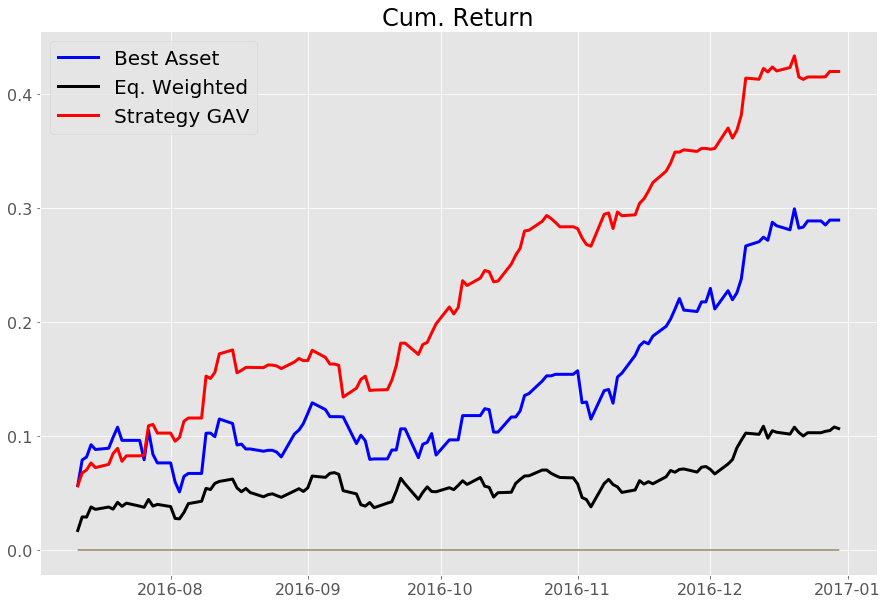

In [167]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(prices_pct.index[Ntr+Nval+T:],eq_test[0:-1:100].T,linewidth=.2) # Plot all (test) equity curves during the training process
ax.plot(prices_pct.index[Ntr+Nval+T:],np.cumprod(1+prices_pct.values[Ntr+Nval+T:,best_asset_tt])-1,'b-',linewidth=3,label='Best Asset') # Benchmark: best asset
ax.plot(prices_pct.index[Ntr+Nval+T:],np.cumprod(1+np.mean(prices_pct.values[Ntr+Nval+T:],axis=1))-1,'k-',linewidth=3,label='Eq. Weighted') # Benchmark: equally weighted CRP
ax.plot(prices_pct.index[Ntr+Nval+T:],np.exp(np.cumsum(best_tt_ret))-1,'r-',label='Strategy GAV',linewidth=3) # Solution chosen by cross-validation on a validation set
ax.legend(loc='upper left',fontsize=20)
ax.tick_params(labelsize=16)
ax.set_title('Cum. Return', fontsize=24)

## Interpretabilidad de los resultados
En esta sección creamos datos sintéticos para evaluar la respuesta al impulso de la red a un movimiento brusco en alguno de los precios.

INFO:tensorflow:Restoring parameters from ./model.ckpt


INFO:tensorflow:Restoring parameters from ./model.ckpt


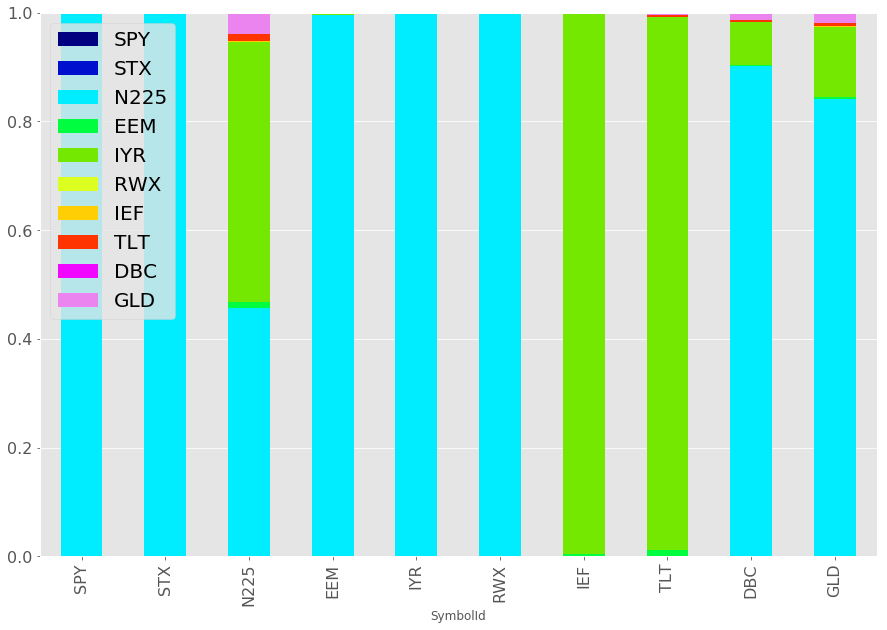

In [84]:
# La visualización va a ser distinta dependiendo del valor de T
# Lo metemos en la red neuronal

with tf.Session() as sess:
    saver.restore(sess,'./model.ckpt')
    if T==1:
        P = pd.DataFrame(np.zeros((N,N)),index=prices_pct.columns,columns=prices_pct.columns) # Cada fila identifica el activo que sufre el impulso
        for n in range(N):
            Z = np.zeros((1,N))
            Z[0,n]=.1
            p = sess.run([DN.probs], feed_dict={DN.input:Z,DN.is_training:False})[0]
            P.iloc[n,:] = p
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax = P.plot.bar(stacked=True,ax=ax,color=[colormap(i) for i in np.linspace(0, 0.9, N)])
        ax.legend(fontsize=20)
        ax.tick_params(labelsize=16)


    else:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        for t in range(T):
            show_legend = (t==T-1) # Enseñamos la leyenda sola una vez
            P = pd.DataFrame(np.zeros((N,N)),index=prices_pct.columns,columns=prices_pct.columns)
            for n in range(N):
                Z = np.zeros((T,N))
                Z[t,n]=-.1
                p = sess.run([DN.probs], feed_dict={DN.input:np.reshape(Z,[1,N*T]),DN.is_training:False})[0]
                P.iloc[n,:] = p                      
            P.plot.bar(stacked=True,ax=ax,width=.1,position=float(t),color=[colormap(i) for i in np.linspace(0, 0.9, N)],legend=show_legend)

        ax.tick_params(labelsize=16)

